In [1]:
import matplotlib.pyplot as plt
import numpy as np

from skimage import feature   
from itertools import chain

import skimage
from skimage.feature import hog
from skimage import data, exposure, io, color

from sklearn.datasets import fetch_lfw_people
from PIL import Image
from skimage import data, transform
from sklearn.feature_extraction.image import PatchExtractor

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV 

from skimage.transform import rescale, resize, downscale_local_mean
import matplotlib.image as mpimg

import cv2

(512, 512, 3)


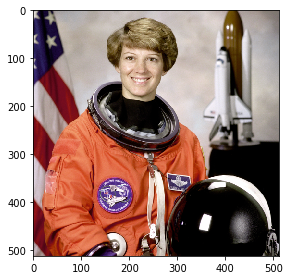

In [2]:
image = data.astronaut()
print(image.shape)
io.imshow(image)

(512, 512)


C:\Users\thaly\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


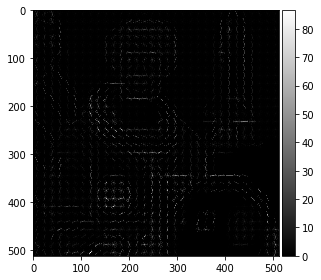

In [3]:
fd, hog_image = hog(image, orientations=9, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

print(hog_image.shape)
io.imshow(hog_image, cmap='gray')

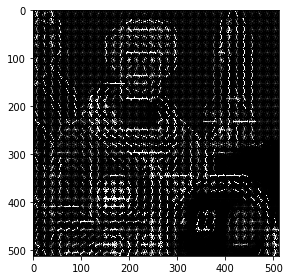

In [4]:
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
io.imshow(hog_image_rescaled)

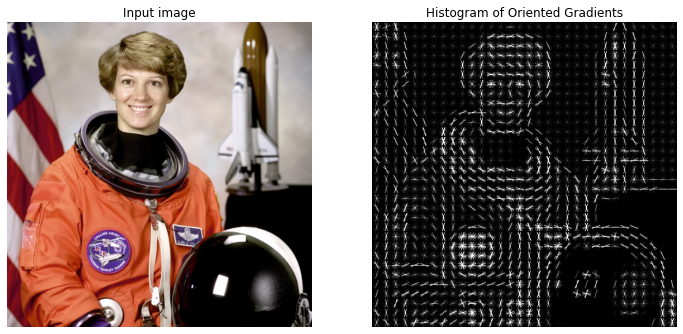

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')


ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

## Pegando exemplos positivos

In [6]:
faces = fetch_lfw_people( data_home=None,
                          color=False,
                          download_if_missing=True)

In [7]:
positive_patches = faces.images
print(len(positive_patches))

13233


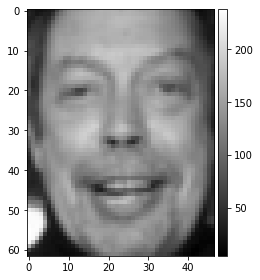

In [8]:
io.imshow(faces.images[0], cmap='gray')

## Pegando exemplos negativos

In [9]:
page = getattr(data, "page")()

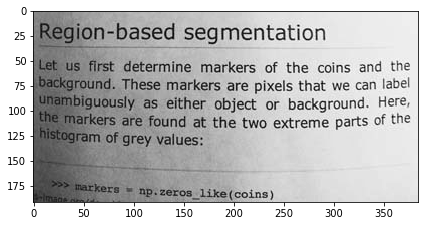

In [10]:
io.imshow(page)

In [11]:
def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

In [12]:
negative_patches = extract_patches(page, 10)

C:\Users\thaly\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


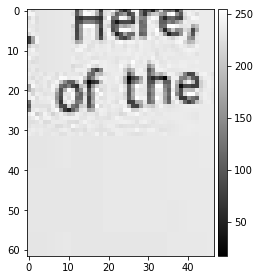

In [13]:
io.imshow(negative_patches[9], cmap="gray")

In [14]:
imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']

images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])

C:\Users\thaly\AppData\Local\Temp/ipykernel_7408/3825901477.py:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  images = [color.rgb2gray(getattr(data, name)())


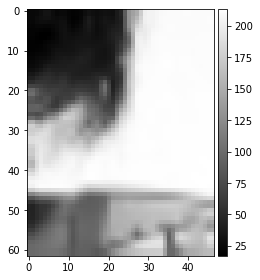

In [16]:
io.imshow(negative_patches[2], cmap="gray")

## Treinamento com base no HoG

In [25]:
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [26]:
grid = GridSearchCV(LinearSVC(dual=False), {'C': [1.0, 2.0, 4.0, 8.0]},cv=3)
grid.fit(X_train, y_train)
grid.best_score_

0.9885504128790507

In [27]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(dual=False)

## Teste com minhas images

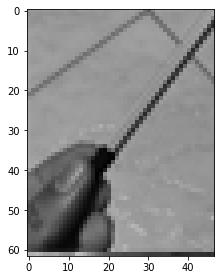

In [20]:
img1 = mpimg.imread('data/labeling2/false01.jpg') 
io.imshow(img1)

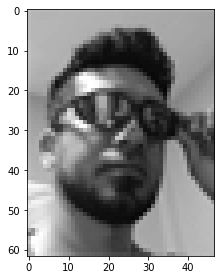

In [21]:
img2 = mpimg.imread('data/labeling2/true01.jpg') 
io.imshow(img2)

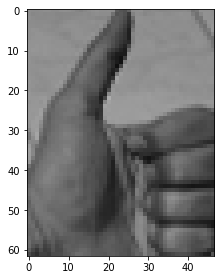

In [22]:
img3 = mpimg.imread('data/labeling2/false02.jpg') 
io.imshow(img3)

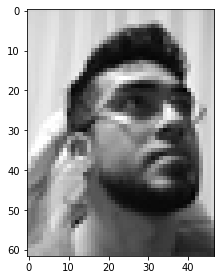

In [23]:
img4 = mpimg.imread('data/labeling2/true02.jpg')
io.imshow(img4)

In [28]:
model.predict([ feature.hog(img) for img in [img1,img2,img3,img4] ])

array([0., 0., 0., 0.])